## Is it a ripe tomato?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

## Data Loading

- Download the image of a ripe and unripe tomato

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('ripe tomato photos', max_images=1)
urls[0]

Searching for 'ripe tomato photos'


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://www.photos-public-domain.com/wp-content/uploads/2018/04/vine-ripened-tomatoes.jpg'

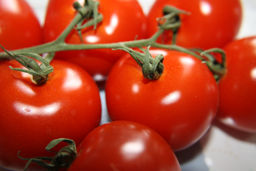

In [5]:
from fastdownload import download_url
dest = 'ripeTomato.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'unripe tomato photos'


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


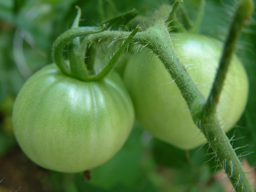

In [6]:
download_url(search_images('unripe tomato photos', max_images=1)[0], 'unripeTomato.jpg', show_progress=False)
Image.open('unripeTomato.jpg').to_thumb(256,256)

In [7]:
searches = 'unripe tomato','ripe tomato'
path = Path('ripe_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'unripe tomato photo'
Searching for 'unripe tomato sun photo'
Searching for 'unripe tomato shade photo'
Searching for 'ripe tomato photo'
Searching for 'ripe tomato sun photo'
Searching for 'ripe tomato shade photo'


## Modelling

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


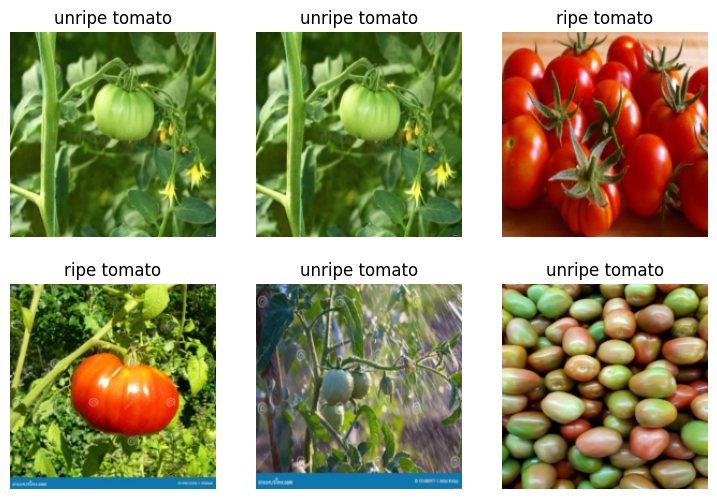

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.094900,0.747015,0.406250,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.340048,0.366130,0.156250,00:05
1,0.218519,0.180726,0.093750,00:01
2,0.173103,0.146421,0.062500,00:01


## Model Prediction

In [13]:
is_ripe,_,probs = learn.predict(PILImage.create('ripeTomato.jpg'))
print(f"This is a: {is_ripe}.")
print(f"Probability it's a ripe tomato: {probs[0]:.4f}")

This is a: ripe tomato.
Probability it's a ripe tomato: 1.0000


In [14]:
is_ripe,_,probs = learn.predict(PILImage.create('unripeTomato.jpg'))
print(f"This is a: {is_ripe}.")
print(f"Probability it's a ripe tomato: {probs[0]:.4f}")

This is a: unripe tomato.
Probability it's a ripe tomato: 0.0005
